# Optimization of Sao Paulo traffic

Lead author: Jules Deschamps.

This notebook presents a simple use case of *information geometry*, in the context of *traffic optimization* in Sao Paulo.
We rely on a dataset listing all traffic jams in Sao Paulo for the past two decades (their location, date, their size, their duration, i.e. how long the traffic was jammed) to propose a solution involving information geometry.

This analysis relies heavily on the geometry of the *Gamma manifold*, which is particularly adapted to addressing this situation, as seen later on.

<center>
    <img src='figures/sao_paulo_traffic.jpg' width=600px>
</center>

<center>
    Figure 1: Sao Paulo: A city with 180km traffic jams -- BBC News
</center>

# 1. Introduction and Motivation

40% of São Paulo residents own a motor vehicle. While this is lower than cities in the United States, it is still higher than most other Latin American cities and São Paulo’s infrastructure was not built to accommodate such a large number of private vehicles. As The Urban Mobility Research Network of São Paulo found, some São Paulo residents spend one month per year in traffic, or 2.4 hours per day. As car ownership increases, and with it further congestion, this time spent in traffic will only grow. In that regard, considering the increase in car ownership and air pollution, even though widening roads only brings a temporary solution, it can alleviate Brazilians of the absurd amount of time they spend in traffic.

In the role of Sao Paulo's city planners, we have been granted a certain amount of resources to solve the congestion problem of Sao Paulo. The issue at hand becomes that of choosing which roads to renovate. More formally, the goal is eventually to reduce the mean expected congestion time in traffic.

### Setup

In [22]:
import os
import subprocess

geomstats_gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(geomstats_gitroot_path[:-1])

print("Working directory: ", os.getcwd())

Working directory:  C:\Users\Jules\Documents\geomstats


In [23]:
import matplotlib.pyplot as plt
import geomstats.backend as gs
import pandas as pd

from tqdm import tqdm

gs.random.seed(2021)

# 2. Dataset description

We have at our disposal a dataset (accessible [here](https://www.kaggle.com/datasets/danlessa/sao-paulo-traffic-jams-since-2001)) containing traffic jam size measurements by CET at several locations on São Paulo between 2001 and 2019, with more than 5M entries.

Available columns:
- passage (str) - Name of the passage
- direction (str)
- type (str) - Indicates if the passage is an expressway (E)
- region (str) - São Paulo region
- timestamp (datetime) - When the traffic jam was measured (UTC-4)
- jam_size (int) - Traffic jam in meters
- segment (str) - Where the passage is located

Our modeling will not take into account the fact that many of the passages/roads must have been renovated between 2001 and 2019. Similarly, the dataset does not offer information on the width of given roads (even though we could base it off of the type of the road), and therefore on their flow rate: this is an obvious flaw in our analysis but it is easy to fix if the relevant data can be accessed.

## Pre-processing the dataset

In [24]:
from geomstats.datasets.utils import load_sao_paulo
df, jam_count = load_sao_paulo()

Some of the columns of the dataset are not necessary for our study: let alone __index__, __type__ and __segment__ do not seem to add any value to the table in our case. In addition, the times (__timestamp__) at which jams are occurring are not relevant in that specific format: it would make much more sense to have the duration of given jam. We also decide to drop the __jam_size__ column.

Additionally, we would want to transform the original dataset so as to access a more relevant table, with features:
- name of the road (primary key = passage + direction for instance, segments are regrouped within same key)
- date (day only)
- duration of the traffic jam (in h)


In [25]:
df

,name,date,duration
0,"Abraão Ribeiro, Av Dr (F) Bairro...",2005-01-12,1.0
1,"Abraão Ribeiro, Av Dr (F) Bairro...",2005-01-20,1.5
2,"Abraão Ribeiro, Av Dr (F) Bairro...",2005-01-21,1.5
3,"Abraão Ribeiro, Av Dr (F) Bairro...",2005-02-24,4.5
4,"Abraão Ribeiro, Av Dr (F) Bairro...",2005-02-28,2.0
...,...,...,...
650519,"Xangai, Vd unico/...",2004-01-16,3.5
650520,"Xangai, Vd unico/...",2004-03-24,4.0
650521,"Xangai, Vd unico/...",2004-03-26,2.0
650522,"Xangai, Vd unico/...",2004-04-29,4.0


Above is the table __df__ of all traffic jams and their durations, for each day.

In [26]:
jam_count_df = pd.DataFrame(jam_count, index=[0])
jam_count = dict(zip(list(jam_count_df.columns), list(jam_count_df.values[0])))
jam_count

{'Abraão Ribeiro, Av Dr (F)               Bairro/Centro                           ': 185,
 'Abraão Ribeiro, Av Dr (F)               Centro/Bairro                           ': 28,
 'Abraão de Morais, Av Prof/Imig          Santos/São Paulo                        ': 1870,
 'Abraão de Morais, Av Prof/Imig          São Paulo/Santos                        ': 852,
 'Abraão de Morais, Av Prof/Imigrantes (F)Santos/São Paulo                        ': 396,
 'Abraão de Morais, Av Prof/Imigrantes (F)São Paulo/Santos                        ': 107,
 'Adolfo Pinheiro e Lgo 13/05             Bairro/Centro                           ': 391,
 'Adolfo Pinheiro e Lgo 13/05             Centro/Bairro                           ': 657,
 'Aliomar Baleeiro, Vd Min                Anchieta/Imigrantes                     ': 3831,
 'Aliomar Baleeiro, Vd Min                Imigrantes/Anchieta                     ': 3191,
 'Aliomar Baleeiro, Vd Min (F)            Anchieta/Imigrantes                     ': 1,
 'Alvareng

__jam_count__ is the dictionary listing all counts of traffic jams for each road.

The following graph plots the distribution of traffic jam counts between 2001 and 2019 for each and every road. It might seem more adapted to focus our renovations on the roads more likely to be impacted by traffic jams, and for that we may drop the roads with a small jam count.

In [27]:
sorted_jam_count = sorted(jam_count, key = jam_count.get)

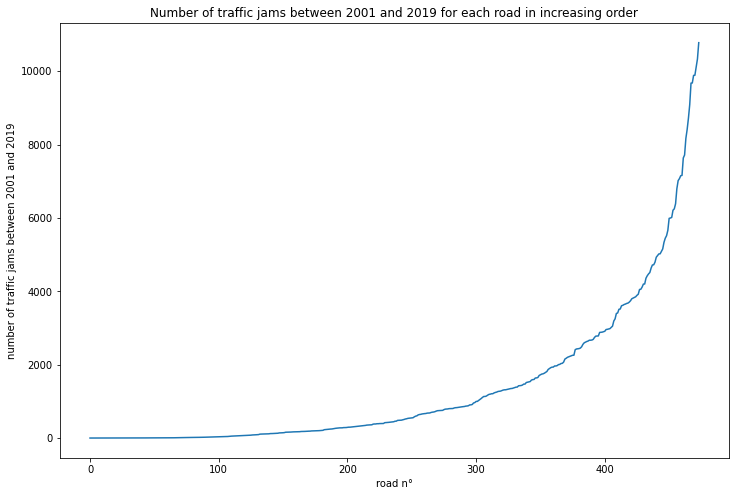

In [28]:
fig = plt.figure(figsize=(12,8))

plt.plot(gs.sort(list(jam_count.values())))
plt.xlabel("road n°")
plt.ylabel("number of traffic jams between 2001 and 2019")
plt.title("Number of traffic jams between 2001 and 2019 for each road in increasing order")
plt.show()

In [29]:
list_jam_count = gs.sort(list(jam_count.values()))
cdf = [list_jam_count[0]]
for i in range(len(list_jam_count)):
    cdf.append(cdf[i] + list_jam_count[i])

cdf = cdf / cdf[-1]

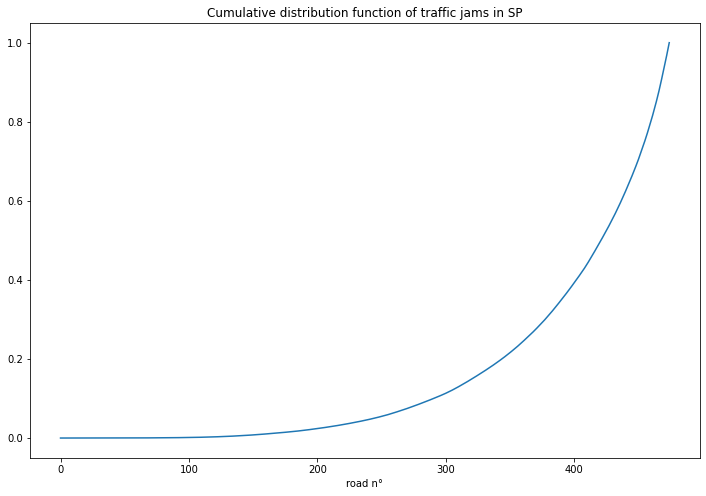

In [30]:
fig = plt.figure(figsize=(12,8))
plt.plot(cdf)

plt.xlabel("road n°")
plt.title("Cumulative distribution function of traffic jams in SP")
plt.show()

The 180 most congestioned roads make up for 90% of all traffic jams in Sao Paulo between 2001 and 2019. That is where we will focus our renovation efforts.

In [31]:
roads_to_renovate = sorted_jam_count[-180:]

# 3. Mathematical modeling

In the following 2 sections, we establish a precise framework, listing the hypotheses and simplifications supporting our model. In particular:
- 3.1. gives an introduction to the Gamma manifold and explains how each road can be represented by a point on it.
- 3.2. justifies the use of information geometry to tackle the problem at hand, by seeing a renovation effort on a given road as a tangent vector based at its associated point.

## 3.1. Road representation: introduction to the Gamma manifold.

The modeling of the study relies heavily on the representation of a traffic jam as a random variable.
In fact, the waiting time in a given traffic jam can be predicted by a Gamma distribution.

### 3.1.1. Hypotheses

We consider that a traffic jam has a fixed exit rate, meaning that on average, in a given unit of time the same count of cars will exit the jam. The waiting time to exit the traffic jam once a car is ahead of the lane is independent of other cars and depends on the road only.

In addition, switching lanes rarely helps, and if so, to a negligible extent; furthermore a car entering the traffic jam will almost always choose the least crowded lane (all drivers are a priori mentally sane). These two observations allow to reduce the modeling of a whole traffic jam to that of a single lane, although only in representation, because cars next to each other will have the same behavior. This means that in our modelling the width of the road is not taken into account, as mentioned in the introduction. 

Both of these hypotheses are central to the model.

### 3.1.2. Model

In a traffic jam, you wait until every car in front of you has exited the traffic jam, meaning that the waiting time for a car entering the jam is merely the sum of the exit times of all the cars in front.

As a $\nu$-exponential process predicts the waiting time until one very first event (where $\nu$ is a rate of a unit of time), a $(k,\, \nu)$-Gamma process will predict the waiting time until the $k$-th event: mathematically, it is the sum of $k$ i.i.d. $\nu$-exponential processes. In the context of congestion time in a traffic jam, we are summing exit times, hence the connection between waiting time and Gamma disribution.

Therefore, the congestion time of the jam follows a Gamma distribution associated to the road. Its parameters are:
- $k$, the length of the car lane (jam size) in arbitrary units;
- $\nu$, the exit time rate of the traffic jam, i.e. the number of cars (in the same arbitrary unit) that exit the traffic jam in a given amount of time, so essentially the speed of the traffic jam.

By arbitrary units we mean that there exists a number $n$ of cars, common to every road, such that $n$ cars will exit the jam every $\frac{1}{\nu}$ (depending on the road) unit of time on average. From this we draw that a road with car length $k$ is in fact as long as $kn$ cars. 

For a given road $r$, we note $T_r$ the congestion time that cars will have to wait in the case the traffic is jammed: $T_r \rightsquigarrow G(k_r, \nu_r)$, with distribution: $$\forall t>0, \, \mathbb{f}(t) = \frac{\nu_r^{k_r}}{\Gamma(k_r)} t^{k_r-1} e^{-\nu_r t}.$$

<center>
    <img src='figures/car_lane.png' width=600px>
</center>

As a road $x_r$ can be represented by two parameters $k_r$ and $\nu_r$, we can consider our space of study to be the space of such parameters (i.e. $\mathbb{(R_+^*)^2}$).

For the following, we denote Gamma distributions' parameters by $(\kappa_r, \gamma_r)$, where $\kappa_r$=$k_r$ (expected jam size) and $\gamma_r$=$\frac{k_r}{\nu_r}$ is the expected congestion time (mean of the Gamma distribution). The space of study is still $\mathbb{(R_+^*)^2}$, and we are instantiating it in the next cell.

In [32]:
import matplotlib.pyplot as plt
from geomstats.information_geometry.gamma import *

space = GammaDistributions()

For instance, on the following graph we are representing 3 roads.

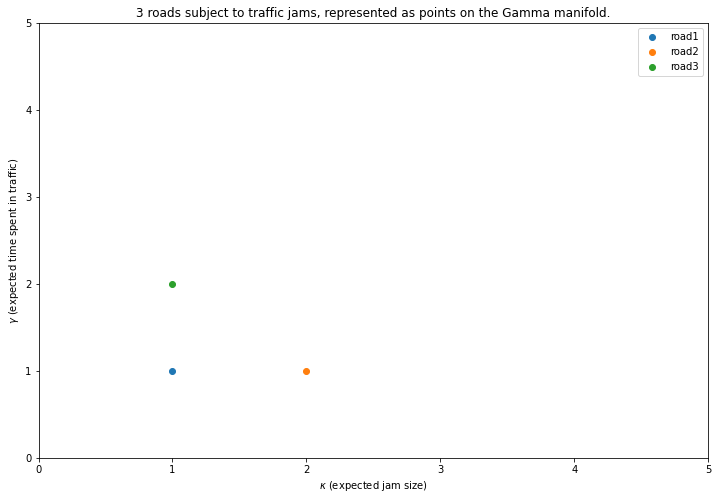

In [33]:
road1 = gs.array([1.0,1.0])
road2 = gs.array([2.0,1.0])
road3 = gs.array([1.0,2.0])
fig = plt.figure(figsize=(12,8))
plt.scatter(*road1, label = 'road1')
plt.scatter(*road2, label = 'road2')
plt.scatter(*road3, label = 'road3')
plt.xlabel("$\\kappa$ (expected jam size)")
plt.ylabel("$\\gamma$ (expected time spent in traffic)")
plt.title("3 roads subject to traffic jams, represented as points on the Gamma manifold.")
plt.legend()
plt.xlim(0,5)
plt.ylim(0,5)
plt.show()

Here:
- road 1 is $(\kappa_1=1,\gamma_1=1)$;
- road 2 is $(\kappa_2=2,\gamma_2=1)$;
- road 3 is $(\kappa_3=1,\gamma_3=2)$.

This means that cars on road 1 will spend half as much time as cars on road 3 in the case of a traffic jam, on average. On the other hand, cars on road 1 and road 2 will spend the same time in traffic on average, but the line is twice as long on road 2.

## 3.2. Mathematical representation of renovation efforts

### 3.2.1. Hypotheses

Renovating a road initially aims at reducing the expected time spent in traffic. This means that for a given road $x_r = (\kappa_r, \gamma_r)$, we want to reduce $\gamma_r$ as efficiently as possible. But, the efficiency of the renovation in that regard heavily depends on the road: one can argue that it is more efficient to renovate a road where traffic jams are frequent than a road on which the traffic is almost fluid. This is where information geometry comes in handy: as a riemannian manifold, the metric of the Gamma manifold is point-dependent.

By seeing renovation as an effort in reducing the expected time in traffic, we can model the advancement of the renovation as the geodesic departing from the point representation of the road, and with initial tangent vector in the direction and orientation $-\gamma$. This reflects the fact that the advancement of the renovation will follow the most natural path, i.e. the distribution of the waiting time of the associated road will change as little as possible throughout the renovation. 

### 3.2.2. Model

We decide to model a renovation effort of budget/effort $r_i$ on road $x_r$ as the tangent vector $r_i \left(\begin{array}{c} 0 \\ -1 \end{array}\right)_{x_r}$, where $\left(\begin{array}{c} 0 \\ -1 \end{array}\right)_{x}$ is the unit tangent vector at $x$ with direction and orientation $-\gamma$. The amount of effort/resources invested in the renovation of a given road is directly represented by the norm of the tangent vector.

Investing as much as $r_i$ renovation resources on road $x_r$ will result in having the renovated road $x_r' = \exp_{x_r} \left( r_i \times \left(\begin{array}{c} 0 \\ -1 \end{array}\right)_{x_r} \right)$, where $\exp_{x}$ is the exponential map at $x$.

The following plot shows a comparison of similar renovations undertaken on the roads in the previous example.

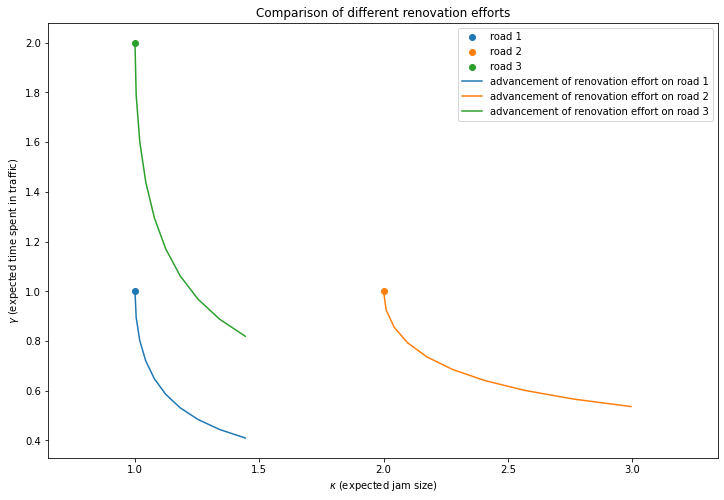

Road 1 renovation: expected waiting time has decreased from 1.0 to 0.409, expected jam size has increased from 1.0 to 1.443.
Road 2 renovation: expected waiting time has decreased from 1.0 to 0.536, expected jam size has increased from 2.0 to 2.995.
Road 3 renovation: expected waiting time has decreased from 2.0 to 0.818, expected jam size has increased from 1.0 to 1.443.


In [34]:
fig = plt.figure(figsize=(12,8))

t = gs.linspace(0,1,10)

plt.scatter(*road1, label = 'road 1')
plt.scatter(*road2, label = 'road 2')
plt.scatter(*road3, label = 'road 3')

effort = gs.array([0.0, -1.0])

effort1 = space.metric.normalize(effort, road1)
renovation1 = space.metric.geodesic(initial_point=road1, initial_tangent_vec=effort1)
renovation1 = renovation1(t)
plt.plot(*gs.transpose(renovation1), label = 'advancement of renovation effort on road 1')

effort2 = space.metric.normalize(effort, road2)
renovation2 = space.metric.geodesic(initial_point=road2, initial_tangent_vec=effort2)
renovation2 = renovation2(t)
plt.plot(*gs.transpose(renovation2), label = 'advancement of renovation effort on road 2')

effort3 = space.metric.normalize(effort, road3)
renovation3 = space.metric.geodesic(initial_point=road3, initial_tangent_vec=effort3)
renovation3 = renovation3(t)
plt.plot(*gs.transpose(renovation3), label = 'advancement of renovation effort on road 3')

plt.xlabel("$\\kappa$ (expected jam size)")
plt.ylabel("$\\gamma$ (expected time spent in traffic)")

plt.title("Comparison of different renovation efforts")

plt.legend()
plt.axis("equal")

plt.show()

print(f"Road 1 renovation: expected waiting time has decreased from {road1[1]} to {str(renovation1[-1,1])[:5]}, expected jam size has increased from {road1[0]} to {str(renovation1[-1,0])[:5]}.")
print(f"Road 2 renovation: expected waiting time has decreased from {road2[1]} to {str(renovation2[-1,1])[:5]}, expected jam size has increased from {road2[0]} to {str(renovation2[-1,0])[:5]}.")
print(f"Road 3 renovation: expected waiting time has decreased from {road3[1]} to {str(renovation3[-1,1])[:5]}, expected jam size has increased from {road3[0]} to {str(renovation3[-1,0])[:5]}.")


We observe that it is much more efficient to renovate road 3 rather than road 1 in terms of gained expected waiting time. This was expected given road 1 is much more fluid than road 3. In terms of relative time gain however, the result is the same: this is specific to Gamma distributions. In addition, renovating road 3 is more efficient than renovating road 2, either in absolute or relative time gain. We observe furthermore that investing similar efforts in renovating roads 3 and 2 result in different evolutions regarding the expected jam size: it increases by 44% in the first case and by as much as 50% in the second one. This becomes delicate especially considering the expected car line on road 2 was already long.

We notice that renovations increase the expected jam size: this can be interpreted as the fact that a renovated roads allows drivers to go faster and the lane becomes longer, in a sense the traffic becomes more diluted. This can be observed in the following plot: renovations increase at once the expected jam size and the expected exit time rate, rendering the road open to much more traffic.

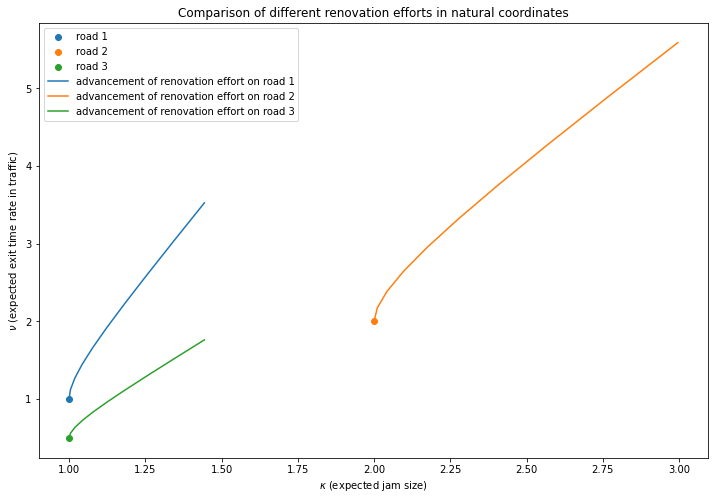

In [50]:
fig = plt.figure(figsize=(12,8))

road1 = space.natural_to_standard(road1)
road2 = space.natural_to_standard(road2)
road3 = space.natural_to_standard(road3)

plt.scatter(*road1, label = 'road 1')
plt.scatter(*road2, label = 'road 2')
plt.scatter(*road3, label = 'road 3')

renovation1 = space.standard_to_natural(renovation1)
renovation2 = space.standard_to_natural(renovation2)
renovation3 = space.standard_to_natural(renovation3)

plt.plot(*gs.transpose(renovation1), label = 'advancement of renovation effort on road 1')
plt.plot(*gs.transpose(renovation2), label = 'advancement of renovation effort on road 2')
plt.plot(*gs.transpose(renovation3), label = 'advancement of renovation effort on road 3')

plt.xlabel("$\\kappa$ (expected jam size)")
plt.ylabel("$\\nu$ (expected exit time rate in traffic)")

plt.title("Comparison of different renovation efforts in natural coordinates")

plt.legend()
plt.show()

The fact that these results validate our observations and expected consequences of renovations legitimates the use of information geometry to model the situation. For instance, a euclidean modeling of the situation would make no sense: all renovations would have the same impact although applied to different roads, because the norm of a tangent vector (i.e. the renovation effort) would be independent of its base point (the road).

A better grasp of this modeling can be encouraged by representing the Gamma manifold as a surface in $\mathbb{R^3}$, equipped with the metric induced by the euclidean metric and isometric to the Gamma manifold.

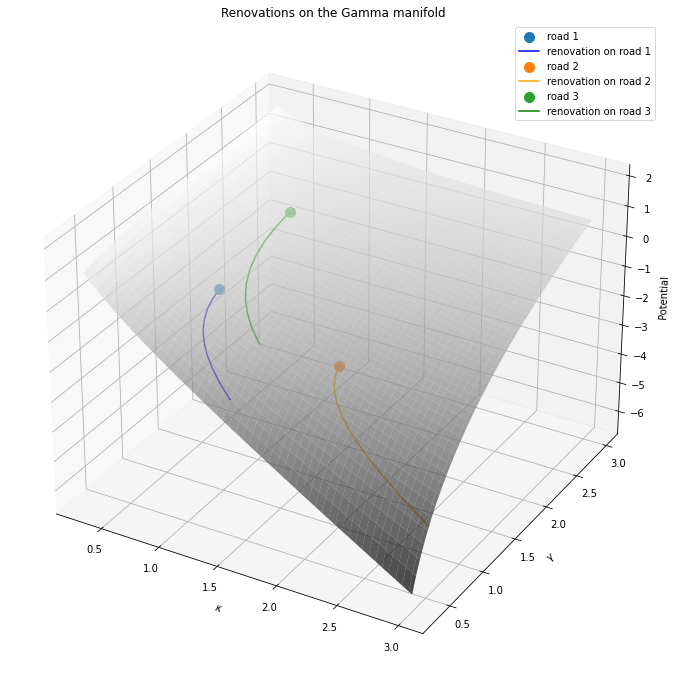

In [35]:
from scipy.special import gamma

def immersion(kappa, g):
    return gs.array(gs.log(gamma(kappa) * (g / kappa)**kappa))

KAPPA = gs.linspace(.3,3,100) 
GAMMA = gs.linspace(.3,3,100)
KAPPA, GAMMA = gs.meshgrid(KAPPA, GAMMA)
POTENTIAL = immersion(KAPPA, GAMMA)

fig = plt.figure(figsize=(16,12))

ax3d = plt.axes(projection='3d')
ax3d.plot_surface(KAPPA, GAMMA, POTENTIAL, cmap=plt.cm.gray, alpha = .7)

ax3d.scatter(*road1, immersion(*road1), s=100, cmap=plt.cm.gray, alpha=1, label='road 1')
ax3d.plot(renovation1[:,0], renovation1[:,1], immersion(renovation1[:,0], renovation1[:,1]), color='b', label='renovation on road 1')

ax3d.scatter(*road2, immersion(*road2), s=100, cmap=plt.cm.gray, alpha=1, label='road 2')
ax3d.plot(renovation2[:,0], renovation2[:,1], immersion(renovation2[:,0], renovation2[:,1]), color='orange', label='renovation on road 2')

ax3d.scatter(*road3, immersion(*road3), s=100, cmap=plt.cm.gray, alpha=1, label='road 3')
ax3d.plot(renovation3[:,0], renovation3[:,1], immersion(renovation3[:,0], renovation3[:,1]), color='g', label='renovation on road 3')
ax3d.set_title('Renovations on the Gamma manifold')
ax3d.set_xlabel("$\\kappa$")
ax3d.set_ylabel("$\\gamma$")
ax3d.set_zlabel('Potential')
plt.legend()

plt.show()

Therefore, the key to optimizing Sao Paulo's traffic obviously lies in maximizing the efficiency of the renovation, with limited renovation resources.

## 3.3. Optimization problem

The aim is to minimize the mean expected congestion time in Sao Paulo, weighted by the frequencies $f_i$ of traffic jams $1 \leq i \leq n$, under the constraint of a total quantity of resources $r$. This reads:

\begin{equation}
\begin{cases}
\min_{(r_i)}  \sum_{i=1}^n f_i \times \exp_{x_i} \left( r_i \times \left(\begin{array}{c} 0 \\ -1 \end{array}\right)_{x_i} \right)_{\gamma} \\
\forall i \in \{1,...,n\}, r_i \geq 0 \\
\sum_{1 \leq i \leq n} r_i = r \\
\end{cases},
\end{equation}


where:
- $(x_i)$ are the roads;
- $\left(\begin{array}{c} 0 \\ -1 \end{array}\right)_{x_i}$ is the unit tangent vector at $x_i$ with direction and orientation $-\gamma$;
- $\exp_{x_i}$ is the exponential map at $x_i$;
- for $x \in G$ (the Gamma manifold), $x_{\gamma}$ is its $\gamma$ coordinate;
- $r_i$ is the resource allocated for renovating road $i$.

#### Remark

We could rewrite the problem in a simpler way analytically, making use of the following results:
- the relative efficiency of renovation (i.e. the ratio of expected congestion times) does not depend on the original expected congestion time of the road ($\gamma$);
- similarly, the length of the car lane of the renovated road does not depend on the original expected congestion time of the road ($\gamma$).

However, we will not use these results to make way for a better computational solution of the problem.


# 4. Dataset processing

First, we associate to each of the roads eligible for renovation its parameters for a Gamma distribution, through a maximum likelihood fit of the durations of traffic jams: __jam_table__ gives, for each road $r$, a sample of size $n_r$ of all the traffic jams and their durations from 2001 to 2019.

In [36]:
names, kappas, gammas = [], [], []

length = len(roads_to_renovate)

pbar = tqdm(total=length)

for road in roads_to_renovate:
    pbar.update(n=1)
    frame = df.loc[df["name"] == road]
    sample = frame["duration"]
    try:
        kappa, gamma = space.maximum_likelihood_fit(sample)
        if not(gs.any(gs.isnan([kappa, gamma]))):
            names.append(road)
            kappas.append(kappa)
            gammas.append(gamma)
    except:
        continue

100%|██████████| 180/180 [13:55<00:00,  4.64s/it]


Having focused on the 180 most congestioned roads makes sense now, as the estimations for the Gamma parameters of the roads are much more relevant. Accounting for all the roads would result in having outliers in our set of roads, rendering the computation far more complex. In addition, roads with a negligible count of traffic jams in such a long time span do not necessarily call for renovation.

That is why, for the following and for the problem at hand, we can consider the following simplification: the roads eligible for renovation represent SP's roads subject to traffic jams, i.e. the exact dataset we want to be working on.

In [37]:
dict_parameters = {"name": names, "kappa": kappas, "gamma": gammas}
data = pd.DataFrame.from_dict(dict_parameters)

To each of the roads eligible for renovation we associate a weight proportional to the number of traffic jams between 2001 and 2019.

In [38]:
good_points = list(data["name"])
weights = list(map(jam_count.get, good_points))
weights = weights / gs.sum(weights)

The 180 most congestioned roads of SP can be represented as follows on the Gamma manifold.

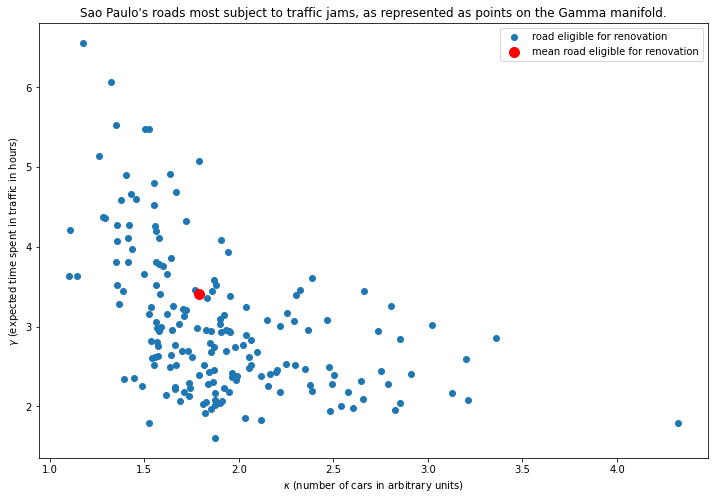

In [39]:
kappa, gamma = data["kappa"], data["gamma"]

fig = plt.figure(figsize=(12,8))

mean = gs.array([gs.sum(weights*kappa), gs.sum(weights*gamma)])

plt.scatter(kappa, gamma, label='road eligible for renovation')
plt.scatter(*mean, color = 'r', s=100, label='mean road eligible for renovation')
plt.xlabel("$\\kappa$ (number of cars in arbitrary units)")
plt.ylabel("$\\gamma$ (expected time spent in traffic in hours)")
plt.title("Sao Paulo's roads most subject to traffic jams, as represented as points on the Gamma manifold.")
plt.legend()
plt.show()

We observe that the vast majority of traffic jams in SP can take from 2 to 6+ hours of congestion time. On the most impactful roads (eligible for renovation), the mean waiting time is 3h 24min.

# 5. Solving the problem at hand

Arbitrarily (and for computational purposes), we are allocated a total of 10 resources to allocate on the renovations. It might seem like the amount of total resources should not matter that much as the original aim is simply knowing how to allocate the total quantity of resources between all the roads eligible for renovation, but renovations are not linear.

In [40]:
total_resources = 10

In [41]:
points = gs.transpose(gs.stack([kappa, gamma]))
n_points = len(points)

We optimize the allocation of resources for renovation here:

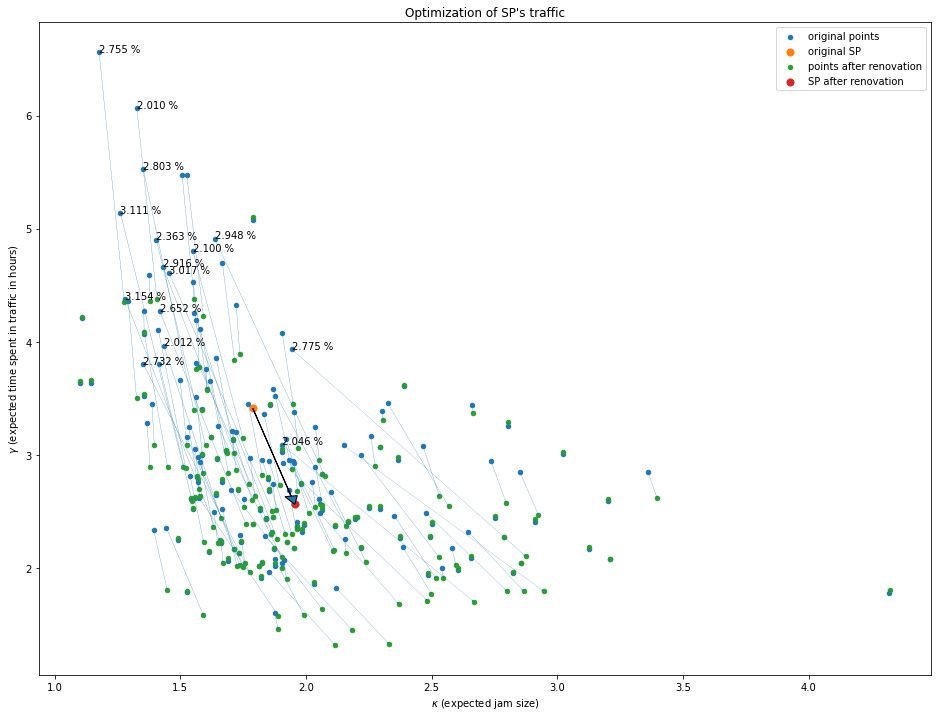

In [42]:
original_SP = gs.sum(gs.einsum("...,...j->...j", weights, points), axis=0)

def rebuilding(point, resources):
    n_points = point.shape[0] if len(point.shape)>1 else 1
    vec = gs.tile([gs.array([0.0,-1.0])], (n_points, 1))
    norm = resources * total_resources
    tangent_vec = gs.einsum("...,...j->...j", norm, vec)
    end_point = space.metric.exp(tangent_vec, point, n_steps=100)
    return end_point

def objective(resources):
    end_points = rebuilding(points, resources)
    gammas = end_points[:,1]
    return gs.mean(weights*gammas)

objective_with_grad = gs.autodiff.value_and_grad(objective, to_numpy=True)

resources = total_resources * weights

res = minimize(
    objective_with_grad,
    resources,
    method="SLSQP",
    constraints=({'type': 'ineq', 'fun': lambda x: total_resources - gs.sum(x)},
    {'type': 'ineq', 'fun': lambda x: x.min()},
    ),
    jac=True,
    options={"disp": False, "maxiter": 100},
    tol=gs.atol,
)

resources = res.x

new_points = rebuilding(points, resources)

fig = plt.figure(figsize=(16,12))

plt.scatter(points[:,0], points[:,1], label = 'original points', s=20)

plt.scatter(*original_SP, label = 'original SP', s=50)

plt.scatter(new_points[:,0], new_points[:,1], label = 'points after renovation', s=20)

for i in range(n_points):
    # geodesic = space.metric.geodesic(initial_point=points[i], initial_tangent_vec=resources[i] * space.metric.normalize(gs.array([0.0,-1.0]), points[i]))
    # geodesic = geodesic(t)
    # plt.plot(*gs.transpose(geodesic))
    plt.arrow(points[i,0], points[i,1], (new_points - points)[i,0], (new_points - points)[i,1], head_width=.01, linestyle ="", length_includes_head = True)
    percentage = resources[i] * 100 / total_resources
    if percentage > 2:
        plt.text(points[i,0], points[i,1], f"{str(percentage)[:5]} %")
    
new_SP = gs.sum(gs.einsum("...,...j->...j", weights, new_points), axis=0)

plt.scatter(*new_SP, label = 'SP after renovation', s=50)

plt.arrow(*original_SP, *(new_SP - original_SP), head_width=.05, linestyle = "-", length_includes_head = True)

plt.xlabel("$\\kappa$ (expected jam size)")
plt.ylabel("$\\gamma$ (expected time spent in traffic in hours)")

plt.title("Optimization of SP's traffic")

plt.legend()

plt.show()

Above, the percentages represent the proportion of the total resources that have been allocated to the renovation of each road: they are visible if greater than 1%.

In [43]:
original_size, original_time = original_SP
new_size, new_time = new_SP

relative_time_reduction = (original_time - new_time) / original_time

original_variance, new_variance = original_time**2 / original_size, new_time**2 / new_size
relative_variance_reduction = (original_variance - new_variance) / original_variance

print(f"Mean expected congestion time has been reduced by as much as {str(relative_time_reduction*100)[:5]} % in Sao Paulo :)")
print(f"Variance in congestion time has been reduced by as much as {str(relative_variance_reduction*100)[:5]} % in Sao Paulo :)")

Mean expected congestion time has been reduced by as much as 24.84 % in Sao Paulo :)
Variance in congestion time has been reduced by as much as 48.33 % in Sao Paulo :)


# Conclusion

We have managed to substantially reduce the mean expected congestion time in SP by as much as 25%, not at great expense of the expected jam sizes! We also happen to have halved the variance of the mean congestion time, rendering long traffic jams rarer. This is a great success!